In [140]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [8, 6]
from metavision_core.event_io import RawReader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Loading the dataset

In [146]:
import dataset

from util import apply

dataset_path = "dataset/0/"

data = dataset.load(dataset_path)

files = data['files']

print(files[0])

raws = apply(RawReader, files)

['dataset/0/1_0/recording_2024-11-13_14-21-07.raw', 'dataset/0/1_0/recording_2024-11-13_14-21-16.raw', 'dataset/0/1_0/recording_2024-11-13_14-21-31.raw', 'dataset/0/1_0/recording_2024-11-13_14-21-44.raw', 'dataset/0/1_0/recording_2024-11-13_14-21-57.raw', 'dataset/0/1_0/recording_2024-11-13_14-22-11.raw', 'dataset/0/1_0/recording_2024-11-13_14-22-23.raw', 'dataset/0/1_0/recording_2024-11-13_14-22-37.raw', 'dataset/0/1_0/recording_2024-11-13_14-22-50.raw', 'dataset/0/1_0/recording_2024-11-13_14-23-02.raw', 'dataset/0/1_0/recording_2024-11-13_14-23-14.raw', 'dataset/0/1_0/recording_2024-11-13_14-23-26.raw']


#### Load the events from the recordings

In [142]:
from util import raw_load_events

events = apply(raw_load_events, raws, dtime = 10000, start_ts=0.1 * 1e6)

#### Visualize the distance effect

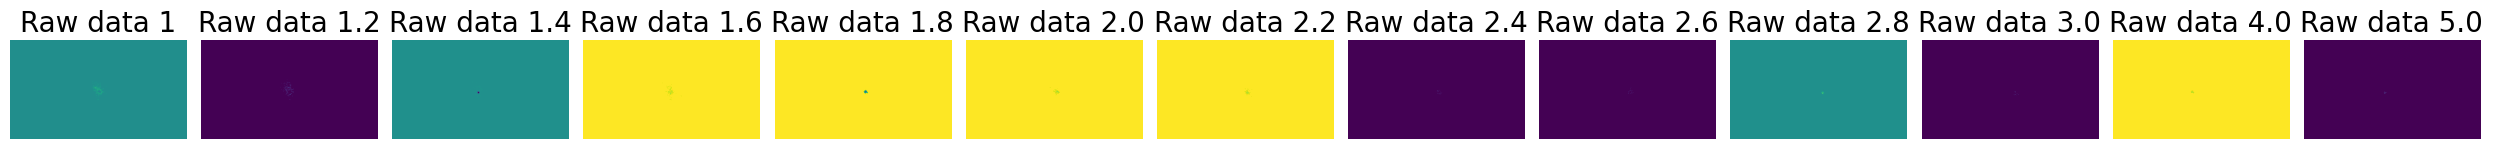

In [153]:
from plotting import visualize_data_raws

xs = [x[0] for x in raws]

labels = data["distances"]

visualize_data_raws(xs, labels=labels, dt=10000)

#### Resample the signal to 1D array

In [143]:
from util import resample_by_polarity

resampled = apply(resample_by_polarity, events)

#### Plot the relationship between the average number of events per period x the disatance

In [154]:
from scipy.signal import find_peaks
import numpy as np

avg_events_per_period = []

frequencies = [float(f) for f in data['frequencies']]
distances = data['distances']
dirs = data['directories']

#plot_avg_events_per_distance(events, resampled, frequencies)

#plot_avg_events_per_frequency(events, frequencies)

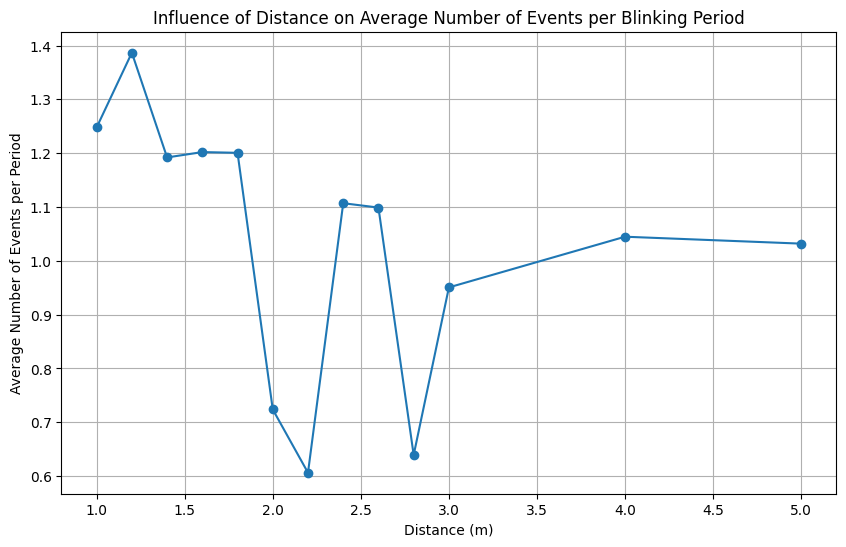

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

avg_events_per_period = []
valid_distances = []  # New list to store distances with valid data

# Assuming 'resampled' is a list of lists or 2D array where resampled[distance_index][freq_index] gives the signal
freq = 4  # Index for the desired frequency (e.g., 10 Hz)
frequency = frequencies[freq]

for distance_index in range(len(distances)):
    signal = resampled[distance_index][freq]
    period = 1 / frequency  # Period in seconds
    period_ms = period * 1000  # Convert period to milliseconds

    # Find peaks in the signal to align it
    peaks, _ = find_peaks(signal, distance=1)
    if len(peaks) < 2:
        continue  # Skip if not enough peaks are found
    start_idx = peaks[0]
    signal = signal[start_idx:]

    # Compute average distance between peaks in ticks
    peak_distances = np.diff(peaks)
    average_peak_distance_in_ticks = np.mean(peak_distances)

    # Use the average peak distance as the period length in ticks
    period_length_in_ticks = int(round(average_peak_distance_in_ticks))
    if period_length_in_ticks == 0:
        continue  # Avoid division by zero

    # Split the signal into periods
    num_periods = len(signal) // period_length_in_ticks
    events_per_period = []
    for i in range(num_periods):
        start = i * period_length_in_ticks
        end = start + period_length_in_ticks
        period_signal = signal[start:end]
        total_events = np.sum(period_signal)
        events_per_period.append(total_events)

    if not events_per_period:
        continue  # Skip if no events were recorded in any period

    # Compute average number of events per period
    avg_events = np.mean(events_per_period)
    avg_events_per_period.append(avg_events)
    valid_distances.append(distances[distance_index])  # Append corresponding distance

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(valid_distances, avg_events_per_period, marker='o')
plt.xlabel('Distance (m)')
plt.ylabel('Average Number of Events per Period')
plt.title('Influence of Distance on Average Number of Events per Blinking Period')
plt.grid(True)
plt.show()
